# Trabalho 1
Matéria: Processamento de Linguagem Natural <br>
Dupla/Matrícula: Bianca Nunes Coelho - 15102880, Raíssa Nunes Coelho - 15102887 <br> 

## Introdução

Multi Class Classification <br>

## Bibliotecas
Bibliotecas do ptyhon utilizadas neste trabalho estão a seguir.

In [31]:
import pandas as pd
import re
import nltk
import spacy
import gensim
import matplotlib.pyplot as plt

## Datasets
Datasets utilizados estão definidos a seguir.

In [32]:
file = "train-00000-of-00001-ecf072e7202447d8.parquet"
df = pd.read_parquet(file, engine= 'pyarrow')

In [33]:
len(df)

3877

In [34]:
df.head(4)

,titulo,texto,link,resumo,categoria,data_hora
0,"Veja a trajetória de Fernando Diniz, em busca ...",Se tem um treinador que sempre foi badalado pe...,https://www.cnnbrasil.com.br/esportes/veja-a-t...,Técnico tricolor e da Seleção Brasileira tem a...,esportes,2023-11-04 12:26:18
1,"Após tempestade com ventos, São Paulo terá sáb...",Após uma tempestade com ventos de mais de 100 ...,https://www.cnnbrasil.com.br/nacional/apos-tem...,"Termômetros devem chegar a 26ºC, esquentando a...",nacional,2023-11-04 12:15:44
2,Como os aplicativos de relacionamento “arruina...,Jenny Nguyen-Don estava com vontade de comer f...,https://www.cnnbrasil.com.br/tecnologia/como-o...,Pessoas em busca de relacionamentos afirmam qu...,tecnologia,2023-11-04 12:15:07
3,Fluminense pode ser o 26º clube a levantar a t...,O Fluminense vai em busca do primeiro título d...,https://www.cnnbrasil.com.br/esportes/fluminen...,"Em busca do título inédito, o Tricolor carioca...",esportes,2023-11-04 12:05:24


## Balanceamento

In [35]:
df['categoria'].value_counts()

esportes           960
nacional           623
internacional      618
economia           562
politica           507
entretenimento     450
tecnologia          44
saude               41
noticias            38
lifestyle           21
branded-content     13
Name: categoria, dtype: int64

<AxesSubplot: >

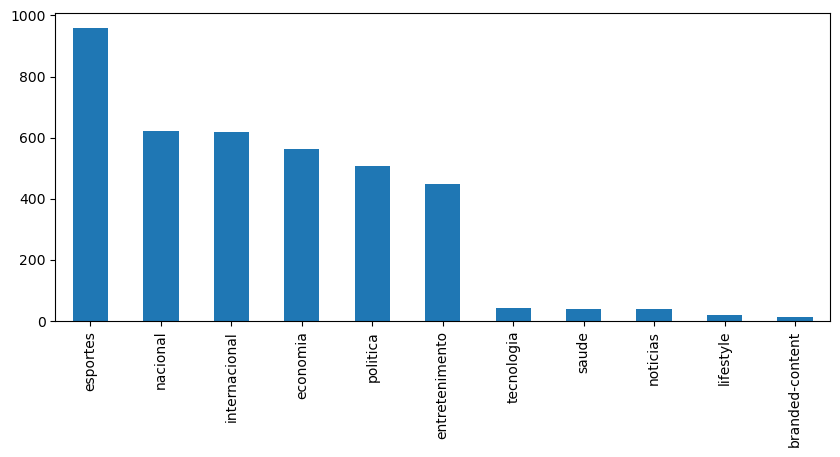

In [36]:
plt.figure(figsize=(10,4))
df.categoria.value_counts().plot(kind='bar')

In [37]:
indice_linha_remover = ['tecnologia',  'saude','noticias','lifestyle','branded-content']

In [38]:
df = df[~df['categoria'].isin(indice_linha_remover)]

In [39]:
df['categoria'].value_counts()

esportes          960
nacional          623
internacional     618
economia          562
politica          507
entretenimento    450
Name: categoria, dtype: int64

In [40]:
# Undersampling
min = df['categoria'].value_counts().min()

amostras = []

for i in df['categoria'].value_counts().index:
    a = df[df['categoria'] == i].sample(min, replace=False)
    amostras.append(a)

df_balanceado = pd.concat(amostras)

In [41]:
df_balanceado['categoria'].value_counts()

esportes          450
nacional          450
internacional     450
economia          450
politica          450
entretenimento    450
Name: categoria, dtype: int64

In [42]:
df_balanceado = df_balanceado.reset_index(drop=True)
df_balanceado.head(5)

,titulo,texto,link,resumo,categoria,data_hora
0,Campeonato Alemão terá mulher como auxiliar té...,O Union Berlin demitiu Urs Fischer nesta quint...,https://www.cnnbrasil.com.br/esportes/campeona...,Union Berlin demitiu Urs Fischer após sequênci...,esportes,2023-11-15 23:09:45
1,Felipe Melo chora antes da decisão da Libertad...,"Experiente jogador do Fluminense, Felipe Melo ...",https://www.cnnbrasil.com.br/esportes/felipe-m...,Defensor se emocionou durante a execução dos h...,esportes,2023-11-04 20:27:44
2,Veja onde deve ser a final da Copa Libertadore...,A direção da AFA (Associação de Futebol da Arg...,https://www.cnnbrasil.com.br/esportes/veja-ond...,Associação argentina ofereceu Buenos Aires par...,esportes,2023-11-08 19:22:42
3,Botafogo x Grêmio ao vivo: acompanhe o jogo pe...,,https://www.cnnbrasil.com.br/esportes/botafogo...,Onde assistir e tempo real dos lances e das es...,esportes,2023-11-09 07:00:08
4,Romário detona e atribui culpa a Edmundo por v...,"Romário, ex-atacante do Vasco, tem em mente um...",https://www.cnnbrasil.com.br/esportes/romario-...,Baixinho não poupou críticas ao ex-companheiro...,esportes,2023-11-16 22:02:06


In [43]:
# pega coluna
text = df_balanceado['texto']
len(text)

2700

In [44]:
categorias = ['esportes','nacional', 'internacional', 'economia', 'politica', 'entretenimento']

## Pré-processamento

In [45]:
for i in range(len(text)):
    text[i] = text[i].lower()

In [46]:
from unidecode import unidecode

for i in range(len(text)):
    text[i] = unidecode(text[i])

In [47]:
for i in range(len(text)):
    text[i] = re.sub(r'[^a-zA-Z\s]', "" ,text[i])

In [48]:
print(text[0])

o union berlin demitiu urs fischer nesta quintafeira  apos  jogos sem vitoria ainda sem uma definicao para o cargo o time alemao montou uma comissao interina com dois profissionais marco grote como treinador e marielouise eta como auxiliar eta e a primeira mulher a ocupar este cargo na historia do campeonato alemao a dupla trabalhou junta no sub do union berlin e comandara a equipe principal ate novo aviso marielouise eta tem  anos e e exjogadora com a camisa do turbine potsdamale conquistou tres titulos do campeonato alemao e um da liga dos campeoes ela se aposentou aos  anos apos sucessivos problemas com lesao a nova auxiliar estara no banco de reservas de jogos do campeonato alemao e da liga dos campeoes da europa na ultima colocacao do grupo c do torneio europeu com um ponto e chances remotas de classificacao o union enfrenta o braga no dia  o time e o lanterna da bundesliga com seis pontos em  jogos   a troca no comando representa o fim de uma era em seus cinco anos no comando urs

In [49]:
token_text = []

for j in text:
    token_text.append(nltk.word_tokenize(j))

In [50]:
print(token_text[0])

['o', 'union', 'berlin', 'demitiu', 'urs', 'fischer', 'nesta', 'quintafeira', 'apos', 'jogos', 'sem', 'vitoria', 'ainda', 'sem', 'uma', 'definicao', 'para', 'o', 'cargo', 'o', 'time', 'alemao', 'montou', 'uma', 'comissao', 'interina', 'com', 'dois', 'profissionais', 'marco', 'grote', 'como', 'treinador', 'e', 'marielouise', 'eta', 'como', 'auxiliar', 'eta', 'e', 'a', 'primeira', 'mulher', 'a', 'ocupar', 'este', 'cargo', 'na', 'historia', 'do', 'campeonato', 'alemao', 'a', 'dupla', 'trabalhou', 'junta', 'no', 'sub', 'do', 'union', 'berlin', 'e', 'comandara', 'a', 'equipe', 'principal', 'ate', 'novo', 'aviso', 'marielouise', 'eta', 'tem', 'anos', 'e', 'e', 'exjogadora', 'com', 'a', 'camisa', 'do', 'turbine', 'potsdamale', 'conquistou', 'tres', 'titulos', 'do', 'campeonato', 'alemao', 'e', 'um', 'da', 'liga', 'dos', 'campeoes', 'ela', 'se', 'aposentou', 'aos', 'anos', 'apos', 'sucessivos', 'problemas', 'com', 'lesao', 'a', 'nova', 'auxiliar', 'estara', 'no', 'banco', 'de', 'reservas', 'de

In [51]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/hworld/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [52]:
from nltk.corpus import stopwords
sw = stopwords.words('portuguese')

In [53]:
for stop in sw:
    for text in token_text:
        for t in text:
            if(t == stop):
                text.remove(t)

In [54]:
print(token_text[0])

['union', 'berlin', 'demitiu', 'urs', 'fischer', 'nesta', 'quintafeira', 'apos', 'jogos', 'vitoria', 'ainda', 'definicao', 'cargo', 'time', 'alemao', 'montou', 'comissao', 'interina', 'dois', 'profissionais', 'marco', 'grote', 'treinador', 'marielouise', 'eta', 'auxiliar', 'eta', 'primeira', 'mulher', 'ocupar', 'cargo', 'historia', 'campeonato', 'alemao', 'dupla', 'trabalhou', 'junta', 'sub', 'union', 'berlin', 'comandara', 'equipe', 'principal', 'ate', 'novo', 'aviso', 'marielouise', 'eta', 'anos', 'exjogadora', 'camisa', 'turbine', 'potsdamale', 'conquistou', 'tres', 'titulos', 'campeonato', 'alemao', 'liga', 'campeoes', 'aposentou', 'anos', 'apos', 'sucessivos', 'problemas', 'lesao', 'nova', 'auxiliar', 'estara', 'banco', 'reservas', 'jogos', 'campeonato', 'alemao', 'liga', 'campeoes', 'europa', 'ultima', 'colocacao', 'grupo', 'c', 'torneio', 'europeu', 'ponto', 'chances', 'remotas', 'classificacao', 'union', 'enfrenta', 'braga', 'dia', 'time', 'lanterna', 'bundesliga', 'seis', 'pon